In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import statsmodels.api as sm
from termcolor import colored
import similaritymeasures
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
from matplotlib import pyplot as plt

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

data1 = read_file('/Users/hasan/Desktop/Anaconda/Research/GPS Trajectory/go_track_tracks.csv')[1:,:-1]
data2 = read_file('/Users/hasan/Desktop/Anaconda/Research/GPS Trajectory/go_track_trackspoints.csv')[1:,1:4]

float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]], dtype = 'object')

trajec = np.array(trajec)

trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], trajec[i][1][:,2][0]], dtype = 'object')
    
trajectory_label_id = np.array(trajectory_label_id, dtype = 'object')
trajectory = np.array(trajectory, dtype = 'object')


min_length = 10
max_length = 1000 #160 for balance data
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
print("l, 163-l=", l, 163-l)

trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id, dtype = 'object')
trajectories = np.array(trajectories, dtype = 'object')

cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2][:,0]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2][:,0]
cars_copy = cars.copy()
buses_copy = buses.copy()
print("len(cars), len(buses)=", len(cars), len(buses))

l, 163-l= 40 123
len(cars), len(buses)= 78 45


In [6]:
a = np.arange(len(cars))
I = np.where((a != 28) & (a != 29))
cars = cars[I]
buses = buses[:-1]
len(cars), len(buses)

(76, 44)

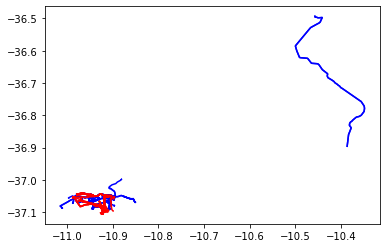

In [23]:
for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color='blue')
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color='red')
plt.savefig(f'/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/car-bus.png', 
            bbox_inches='tight', dpi=200)
plt.show()

In [9]:
data_1 = []
data_2 = []
for i in range(226):
    path = '/Users/hasan/Desktop/Anaconda/Research/car-bus-generated/data_1/'+str(i)+'.csv'
    data_1.append(np.array(pd.read_csv(path, header=None)))

for i in range(220):
    path = '/Users/hasan/Desktop/Anaconda/Research/car-bus-generated/data_2/'+str(i)+'.csv'
    data_2.append(np.array(pd.read_csv(path, header=None)))

data_1 = np.array(data_1, dtype = "object")
data_2 = np.array(data_2, dtype = "object")
print("data_1.shape, data_2.shape=", data_1.shape, data_2.shape)

data_1.shape, data_2.shape= (226,) (220,)


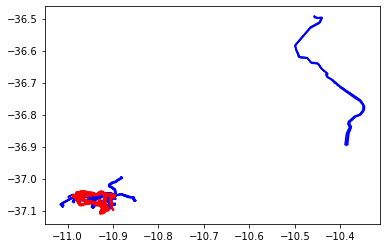

In [10]:
for i in range(len(data_1)):
    plt.plot(data_1[i][:,0], data_1[i][:,1], color='blue')
for i in range(len(data_2)):
    plt.plot(data_2[i][:,0], data_2[i][:,1], color='red')
plt.savefig(f'/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/Simulated-car-bus-446.png', 
            bbox_inches='tight', dpi=200)
plt.show()

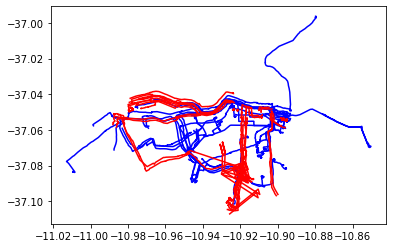

In [11]:
for i in range(0,222, 6):
    plt.plot(data_1[i][:,0], data_1[i][:,1], color='blue')
for i in range(0,220,6):
    plt.plot(data_2[i][:,0], data_2[i][:,1], color='red')
plt.savefig(f'/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/Simulated-car-bus-446-36.png', 
            bbox_inches='tight', dpi=200)
plt.show()

In [12]:
a, c = np.min((np.min([np.min(data_1[i], axis=0) for i in range(len(data_1))], axis=0), 
       np.min([np.min(data_2[i], axis=0) for i in range(len(data_2))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(data_1[i], axis=0) for i in range(len(data_1))], axis=0), 
               np.max([np.max(data_2[i], axis=0) for i in range(len(data_2))], axis=0)), axis=0)

print("length and width:", np.round(b - a, decimals=2), np.round(d - c, decimals=2))

length and width: 0.67 0.62


In [13]:
def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

# KNN with Soft-DTW with matrix saving method

In [24]:
def calculate_dists_soft_dtw(data1, data2, gamma, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            D = SquaredEuclidean(data[i], data[j])
            sdtw = SoftDTW(D, gamma=gamma)
            A.append(sdtw.compute())
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')
    total_time = time.time() - start_time
    return total_time

In [17]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN-soft-dtw/car-bus-generated-soft-dtw-446.csv'
calculate_dists_soft_dtw(data_1, data_2, gamma=1e-15, path=path)

69.32698512077332

In [28]:
def KNN_with_dists_soft_dtw(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [29]:
def KNN_average_error_soft_dtw(data1, data2, num_trials, path_to_dists):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_soft_dtw(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with soft dtw", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [22]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN-soft-dtw/car-bus-generated-soft-dtw-446.csv'

E = KNN_average_error_soft_dtw(data_1, data_2, num_trials=50, path_to_dists=path)
E[0]

num_trials = 50
total time = 3.7435810565948486


,Classifier,Train Error,Test Error,std
1,KNN with soft dtw,0.063,0.124,0.0315
